In [2]:
#first i need data from a previous run
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime
from scipy.optimize import curve_fit
import math
from scipy import asarray as ar,exp
import pylab as plb
import tqdm
from tqdm import tqdm
import time
import progressbar

In [3]:
dataset = np.load("/home/roberts/O-PPAC/recomplied_dataset.npy")
all_data = dataset[ : , :132]
all_labels = dataset[: , -2:]

print(all_data.shape)
print(all_labels.shape)

(338922, 132)
(338922, 2)


In [4]:
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

0.8395246220687987


In [5]:
#separate the test data as done above
x1_data_all = (all_data[: , :33])*100
x2_data_all = (all_data[:, 33:66])*100
y1_data_all = (all_data[:, 66:99])*100
y2_data_all = (all_data[:, 99:132])*100

#labels kept so they have the same indices
x_label_all = all_labels[ : , 0 ]
y_label_all = all_labels[ : , 1 ]

print(x1_data_all.shape)
print(x_label_all.shape)

print(np.min(x1_data_all))

(338922, 33)
(338922,)
0.0


In [6]:
#gaussian fit function
def gaussianpdf(x, k, sigma, mu):
    return k*np.exp(-(x-mu)**2/(2*sigma**2))

In [103]:
#function to (hopefully) fit gaussians (and thus, centroids which is what we want) onto all data sets
def centroidmm(x, y):
    try:
        if np.max(y) > 20:
            kvalue = np.max(y)+(np.max(y)/2)
        elif np.max(y) == 0:
            kvalue = 1
        else:
            kvalue = np.max(y)
        popt, _ = curve_fit(gaussianpdf, x, y, bounds=(0, [kvalue,10., 33.]))
        return (popt[2]/33)*100-48 #converts location from diode number to mm (measurement of x_pos & y_pos)
    except RuntimeError:
        return -5555

#function to (hopefully) fit gaussians (and thus, centroids which is what we want) onto all data sets
def centroiddn(x, y):
    try:
        if np.max(y) > 20:
            kvalue = np.max(y)+(np.max(y)/2)
        elif np.max(y) == 0:
            kvalue = 1
        else:
            kvalue = np.max(y)
        popt, _ = curve_fit(gaussianpdf, x, y, bounds=(0, [kvalue,10., 33.]))
        return popt[2]
    except RuntimeError:
        return -5555

In [8]:
def find_peak_error(arr1data, arr2data):
    error_indices1 = np.where(arr1data == -5555 )
    error_indices2 = np.where(arr2data == -5555 )
        
    arr1data_df = pd.DataFrame(arr1data)
    arr2data_df = pd.DataFrame(arr2data)
        
    error_indices = np.unique(np.concatenate([error_indices1, error_indices2], axis = 1))
        
    return error_indices

In [9]:
def remove_peak_error(arr1data, arr2data, removearr):
    
    arr1data_df = pd.DataFrame(arr1data)
    arr2data_df = pd.DataFrame(arr2data)
        
    arr1data_df_fixed = arr1data_df.drop(arr1data_df.index[removearr])
    arr2data_df_fixed = arr2data_df.drop(arr2data_df.index[removearr])
        
    arr1data_fixed = arr1data_df_fixed.to_numpy()
    arr2data_fixed = arr2data_df_fixed.to_numpy()
        
    return arr1data_fixed, arr2data_fixed

In [10]:
#conversions from diode number to millimeters and vice versa
#might need to be updated if Yassid sends a better method of converting
def diodenum_to_mm(arr1data):
    convert = []
    for i in range(len(arr1data)):
        mm = (arr1data[i] /33)*100 - 48
        convert.append(mm)
    return np.concatenate(convert)

def mm_to_diodenum(arr1data):
    convert = []
    for i in range(len(arr1data)):
        diodenum = ((arr1data[i] + 48)/100)*33
        convert.append(diodenum)
    return np.concatenate(convert)

In [11]:
def average(arr1data, arr2data):
    avg = (arr1data + arr2data)/2
    return avg

In [257]:
rangemin = 150000
rangemax = 200500

ranges = (rangemin, rangemax)

range_size = rangemax - rangemin

In [167]:
x1_peaks_mini = []
for i in tqdm(range(rangemin,rangemax)):
    x1_dn = centroiddn(np.arange(0,33,1), x1_data_all[i,:])
    x1_peaks_mini.append(x1_dn)
    
x1_peaks_mini = np.array(x1_peaks_mini)
np.save("x1_peaks_file_mini_1", x1_peaks_mini)

100%|██████████| 50500/50500 [05:12<00:00, 161.55it/s]


In [168]:
x2_peaks_mini = []
for i in tqdm(range(rangemin,rangemax)):
    x2_dn = centroiddn(np.arange(0,33,1), x2_data_all[i,:])
    x2_peaks_mini.append(x2_dn)
    
x2_peaks_mini = np.array(x2_peaks_mini)
np.save("x2_peaks_file_mini_1", x2_peaks_mini)

100%|██████████| 50500/50500 [14:02<00:00, 59.92it/s]  


In [169]:
y1_peaks_mini = []
for i in tqdm(range(rangemin,rangemax)):
    y1_dn = centroiddn(np.arange(0,33,1), y1_data_all[i,:])
    y1_peaks_mini.append(y1_dn)
    
y1_peaks_mini = np.array(y1_peaks_mini)
np.save("y1_peaks_file_mini_1", y1_peaks_mini)

100%|██████████| 50500/50500 [06:16<00:00, 134.28it/s]


In [170]:
y2_peaks_mini = []
for i in tqdm(range(rangemin,rangemax)):
    y2_dn = centroiddn(np.arange(0,33,1), y2_data_all[i,:])
    y2_peaks_mini.append(y2_dn)
    
y2_peaks_mini = np.array(y2_peaks_mini)
np.save("y2_peaks_file_mini_1", y2_peaks_mini)

100%|██████████| 50500/50500 [05:51<00:00, 143.55it/s]


In [171]:
#importing data so I'm not running over the other kernels
x1_peaks_mini = np.load("x1_peaks_file_mini_1.npy")
x2_peaks_mini = np.load("x2_peaks_file_mini_1.npy")
y1_peaks_mini = np.load("y1_peaks_file_mini_1.npy")
y2_peaks_mini = np.load("y2_peaks_file_mini_1.npy")

print(len(x1_peaks_mini))
print(len(x2_peaks_mini))
print(len(y1_peaks_mini))
print(len(y2_peaks_mini))

50500
50500
50500
50500


In [172]:
x_errors_remove_mini = find_peak_error(x1_peaks_mini, x2_peaks_mini)
y_errors_remove_mini = find_peak_error(y1_peaks_mini, y2_peaks_mini)

all_error_indices_mini = np.unique(np.concatenate([x_errors_remove_mini, y_errors_remove_mini]))

error_indices_mini = np.array(all_error_indices_mini)
np.save("error_indices_mini", error_indices_mini)

In [173]:
fixed_x1_peaks_mini, fixed_x2_peaks_mini = remove_peak_error(x1_peaks_mini, x2_peaks_mini, all_error_indices_mini)

x_peaks_mini = average(fixed_x1_peaks_mini, fixed_x2_peaks_mini)

x_peaks_mm_mini = diodenum_to_mm(x_peaks_mini)
print(x_peaks_mm_mini)

[-7.57391264 -7.64592289 -7.56676355 ... 16.88492011 16.3940202
 16.79216078]


In [174]:
fixed_y1_peaks_mini, fixed_y2_peaks_mini = remove_peak_error(y1_peaks_mini, y2_peaks_mini, all_error_indices_mini)

y_peaks_mini = average(fixed_y1_peaks_mini, fixed_y2_peaks_mini)

y_peaks_mm_mini = diodenum_to_mm(y_peaks_mini)
print(y_peaks_mm_mini)

[-15.27398716 -15.38566505 -15.99146055 ... -27.57301109 -27.84489615
 -27.80393101]


In [175]:
x_label_all_mini = x_label_all[rangemin:rangemax]
y_label_all_mini = y_label_all[rangemin:rangemax]

x_label_all_df_mini = pd.DataFrame(x_label_all_mini)
y_label_all_df_mini = pd.DataFrame(y_label_all_mini)

x_label_all_df_fixed_mini = x_label_all_df_mini.drop(x_label_all_df_mini.index[error_indices_mini])
y_label_all_df_fixed_mini = y_label_all_df_mini.drop(y_label_all_df_mini.index[error_indices_mini])

x_label_all_arr_mini = x_label_all_df_fixed_mini.to_numpy()
y_label_all_arr_mini = y_label_all_df_fixed_mini.to_numpy()

print(x_label_all_arr_mini.shape)
print(x_peaks_mm_mini.shape)
print(y_label_all_arr_mini.shape)
print(y_peaks_mm_mini.shape)

(47345, 1)
(47345,)
(47345, 1)
(47345,)


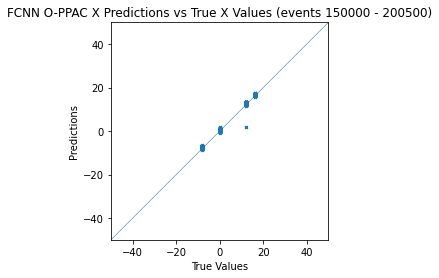

In [176]:
#graph showing the accuracy of gaussian fit by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels_mini = []
for i in range(len(x_label_all_arr_mini)):
    new_x_labels_mini.append([x_label_all_arr_mini[i]])
np.array(new_x_labels_mini)

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels_mini, x_peaks_mm_mini, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC X Predictions vs True X Values (events %5.0f - %5.0f)" %tuple(ranges))
plt.show()

In [222]:
#to find the locations of largest error within my predicted y values (same as the x code above but specific to y)
x_error_mini = []

for i in range(len(x_peaks_mm_mini)):
    x_error_test_mini = x_peaks_mm_mini[i] - x_label_all_arr_mini[i]
    x_error_mini.append(x_error_test_mini)

#print(x_error_mini)  

xerror_list_mini = [i for i in x_error_mini if abs(i) >= 5]
#xerror_list_mini.sort(reverse = True)
print(len(xerror_list_mini))
xerror_list_c_mini = np.squeeze(xerror_list_mini)
print(xerror_list_c_mini)

3
[-10.00000017 -10.00000017 -10.00000017]


In [237]:
print(x1_data_all[true_index_x[0]])

[[ 0.33762019  0.          0.          0.67524038  0.          0.
   0.33762019  0.          0.          0.33762019  0.          2.70096152
   7.42764419 13.84242781 11.47908648 14.85528838 12.82956724 10.12860571
   3.3762019   0.33762019  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.67524038  0.        ]]


[138422, 138423]


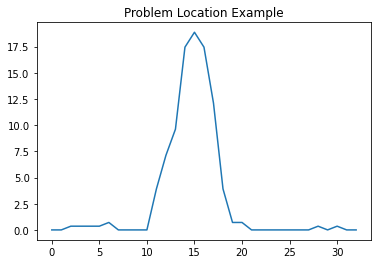

In [252]:
#graph the location of areas with larger error (bad_yvalue must come from y-prediction)
bad_xvalue_mini = -10.00000017
x_test_locat_mini = np.isclose( x_error_mini, bad_xvalue_mini, .0001)

true_index_x = list(set(np.squeeze(338922 - (rangemax - x_test_locat_mini))))
print(true_index_x)

plt.title('Problem Location Example')
plt.plot(x1_data_all[true_index_x[1]])
plt.show()

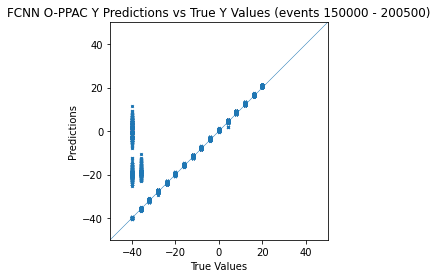

In [177]:
#graph showing the accuracy of gaussian fit by comparing predicted and true x values
#should be as close to the diagonal as possible
new_y_labels_mini = []
for i in range(len(y_label_all_arr_mini)):
    new_y_labels_mini.append([y_label_all_arr_mini[i]])
np.array(new_y_labels_mini)

a = plt.axes(aspect='equal')

plt.scatter(new_y_labels_mini, y_peaks_mm_mini, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values (events %5.0f - %5.0f)" %tuple(ranges))
plt.show()

In [220]:
#to find the locations of largest error within my predicted y values (same as the x code above but specific to y)
y_error_mini = []

for i in range(len(y_peaks_mm_mini)):
    y_error_test_mini = y_peaks_mm_mini[i] - y_label_all_arr_mini[i]
    y_error_mini.append(y_error_test_mini)

#print(y_error_mini)  

yerror_list_mini = [i for i in y_error_mini if abs(i) >= 5]
yerror_list_mini.sort(reverse = True)
print(len(yerror_list_mini))
yerror_list_c_mini = np.squeeze(yerror_list_mini)
print(yerror_list_c_mini)

1423
[51.70970238 49.43300902 49.37287876 ... 13.54557182 13.37595329
 13.10764931]


[138422, 138423]


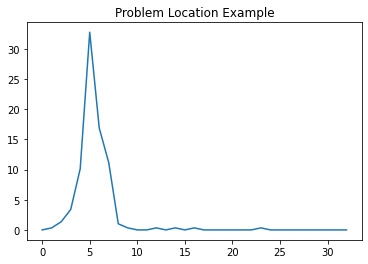

In [253]:
#graph the location of areas with larger error (bad_yvalue must come from y-prediction)
bad_yvalue_mini = 51.70970238 
y_test_locat_mini = np.isclose( y_error_mini, bad_yvalue_mini, .0001)

true_index_y = list(set(np.squeeze(338922 - (rangemax - y_test_locat_mini))))
print(true_index_y)

plt.title('Problem Location Example')
plt.plot(y1_data_all[true_index_y[0]])
plt.show()

In [285]:
#basic gaussian fit stuff; needs x and y inputs for all data points; index is both for the y data and for lower code
index = 138450
x = np.arange(0,33,1)
y = x1_data_all[index,:]

print(y)
x_label_all_arr_mini_index = range_size - (rangemax - index)

#the true location of the peak as given by the label for that event
x_peak_true_value = ((x_label_all_arr_mini[x_label_all_arr_mini_index]+48)/100)*33
x_peak_fit_value = x_peaks_mini[x_label_all_arr_mini_index]

[ 0.          0.          0.          0.          0.          0.
  0.33009953  0.33009953  0.          0.          0.          2.31069669
  5.61169196  9.57288628 14.19427965 15.84477729 12.21368249  5.94179148
  3.63109479  0.99029858  0.33009953  0.66019905  0.33009953  0.
  0.33009953  0.          0.          0.          0.33009953  0.
  0.33009953  0.          0.33009953]


In [286]:
#curve fit code; bounds might be able to be played with still to improve model (specifically sigma in index 1)
#trying new stuff to better balance k based on the input data
if np.max(y) > 20:
    kvalue = np.max(y)+(np.max(y)/2)
elif np.max(y) == 0:
    kvalue = 1
else:
    kvalue = np.max(y)

popt, _ = curve_fit(gaussianpdf, x, y, bounds=(0, [kvalue,10., 33.]))
print(popt[2])
print(x_peak_true_value)
print(x_peak_fit_value)

14.69539740250097
[19.8]
[20.03482332]


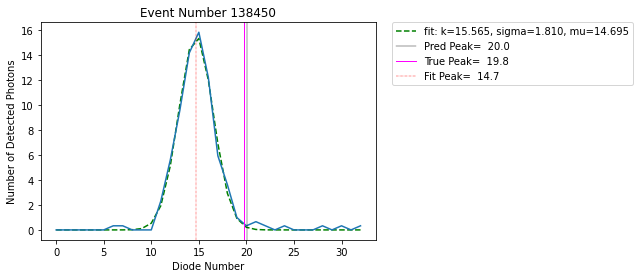

In [287]:
#plotting gaussian to make sure it looks logically correct
plt.plot(x, gaussianpdf(x, *popt), 'g--', label='fit: k=%5.3f, sigma=%5.3f, mu=%5.3f' % tuple(popt))
plt.plot(x1_data_all[index,:])
plt.axvline(x = x_peak_fit_value, color = "black", linewidth=.4, label='Pred Peak= %5.1f' %x_peak_fit_value)
plt.axvline(x = x_peak_true_value, color = "magenta", linewidth=1, label='True Peak= %5.1f' % x_peak_true_value)
plt.axvline(x = popt[2], color = "red", linewidth=.4, linestyle='dashdot', label='Fit Peak= %5.1f' %popt[2])
plt.title('Event Number %5.0f' %index)
plt.xlabel('Diode Number')
plt.ylabel('Number of Detected Photons')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()